# **Focal Loss Test**

In this notebook we will explore a basic pipeline for 15min interval stock data. We will be working with a portfolio of highly correlated stocks: AAPL, GOOG, QCOM, and TSLA. We will train our models using the Balanced Focal Loss function and compare it to our previous performan using Categorical Cross Entropy Loss. These stocks were highly correlated around Aug - Oct 2022. The stock dataset contains timestamps, prices and trading volume, but does not contin any target variables.
- Timestamps &#8594; Interval
- Open/Close/High/Low Prices &#8594; Ratio
- Trading Volume &#8594; Ratio

To use the timestamps we will sinusoidally encode them. We will also add engineered features such as the price difference.

 We will create the target variable by taking the midpoint of Open/Close prices for M future days and then averaging these values. This target variable is Oridnal and has 3 possible classes: 
- 0 - downward price movement
- 1 - no change
- 2 - upward price movement

The price movements are derived by a threshold that is defined using the IQR method to detect outliers. Currently we use a limit of 1, and every Q1 outlier is classified as "0 - downward price movement", every Q3 outlier is classified as "2 - upward price movement", and all inliers are classified as: "1 - no change".

#### NOTE:
This dataset has discontinuities after each trading day (i.e. from final afterhours trade until the first afterhours trade the next day). It is possible that other afterhours activities could have occured to impact the prices during this time period. 

## Models

The main model we will be testing in this notebook is a Transformer Encoder. Typically a Transformer has an Encoder and Decoder portion, where the Encoder learns information about which parts of the input sequence are relevant to eachother. The Decoder does the opposite, it takes the continuouss representation learned by the Encoder and learns to generate an ordered output sequence. For the Time Series Classifiecation problem it is unecessary to include the Decoder, we can simply use the Encoder to learn relative correlations of the inputs and add a Vanilla Feed Forward Neural Network to the end of the Encoder Blocks to obtain the desired classification. [Source](https://userweb.cs.txstate.edu/~amk181/AIME_LSTM_Attention_vs_Transformer.pdf).

The Transformer Encoder also relies on positional encoding in order to implement this, we will first project the input vectors into high dimensional space as done [here](https://arxiv.org/pdf/2010.02803.pdf), and then add the positional Encoding as done in the [original paper](https://arxiv.org/pdf/1706.03762.pdf).


In order to compare how effective the Transformer is in modeling seuqential data, we will compare its results to:
- Baseline Model (uses previous predictions)
- Linear Model
- Neural Network
- LSTM

### Library Import

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import pandas_ta as ta
import tensorflow as tf
import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)
%matplotlib inline

### Local Imports

Get base dir for imports, this allows us to look in the main algotrading folder to import local modules

In [4]:
BASE_DIR = os.path.abspath(os.path.join(os.path.abspath('..'), '..'))
sys.path.append(BASE_DIR)

In [5]:
from data_utils import *
from data_pipeline import *
from window_generator import WindowGenerator
from models.basic_transformer import TransformerModel

### Ensure that GPU is available

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Get the Data
Place all stocks in a Dictionary of DataFrames

In [ ]:
from glob import glob
import re

# get all data .csvs
data_paths = glob(os.path.join(BASE_DIR, r'data\raw\15min\*.csv'))

# get stock DataFrames dict
stock_dfs = get_stocks(data_paths, tgt_window=4, iqr_lim=0.25)

### Plot the of number of each class for each stock

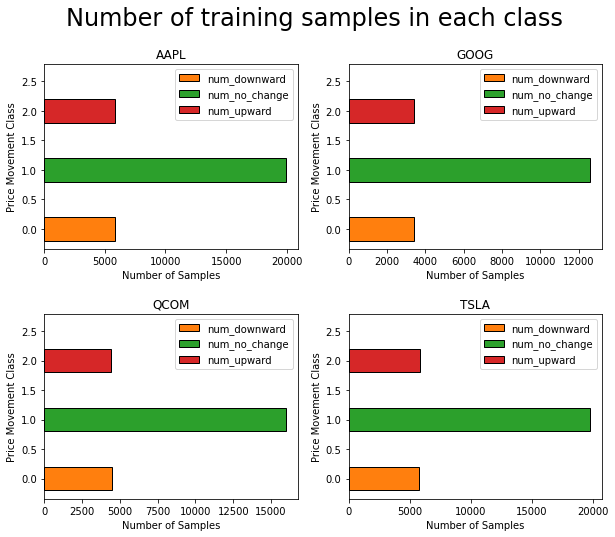

In [8]:
fig = plt.figure(figsize=(10, 8))

for i, name in enumerate(stock_dfs.keys()):
    # get plotting axes
    ax = plt.subplot(2, 2, i + 1)

    # get stock DataFrame
    df = stock_dfs[name]

    # compute class counts
    down = np.sum(df.price_change == 0)
    none = np.sum(df.price_change == 1)
    up = np.sum(df.price_change == 2)

    ax.barh([2.25], [0]) # expand to fit the legend
    ax.barh([0], [down], height=0.4, edgecolor='k', label='num_downward')
    ax.barh([1], [none], height=0.4, edgecolor='k', label='num_no_change')
    ax.barh([2], [up], height=0.4, edgecolor='k', label='num_upward')
    ax.set_title(name)
    ax.set_xlabel('Number of Samples')
    ax.set_ylabel('Price Movement Class')
    ax.legend();

# set main title
fig.suptitle('Number of training samples in each class', size=24)

# add a bit of space
fig.subplots_adjust(hspace=0.35);


### NEW - Add Day of Week to features and remove later
We will use the dayofweek to remove windows containing non-consecutive data

In [9]:
for name in stock_dfs.keys():
    df = stock_dfs[name]
    df['dayofweek'] =  df.index.dayofweek

    stock_dfs[name] = df

In [10]:
stock_dfs['AAPL'].iloc[:3, :]

,Open,High,Low,Close,price_trend,log_volume,sin_day,cos_day,sin_hour,cos_hour,sin_minute,cos_minute,open_diff,close_diff,high_diff,low_diff,log_vol_diff,price_change,dayofweek
Time,,,,,,,,,,,,,,,,,,,
2020-10-23 04:30:00,115.259043,115.259043,115.100951,115.170116,-0.188970,9.848556,-0.433884,-0.900969,0.866025,0.500000,5.665539e-16,-1.000000e+00,0.395230,-0.039523,0.049404,0.237138,9.848556,0,4
2020-10-23 04:45:00,115.179997,115.199758,114.942859,115.021905,-0.129685,9.622384,-0.433884,-0.900969,0.866025,0.500000,-1.000000e+00,-1.836970e-16,-0.079046,-0.148211,-0.059285,-0.158092,9.622384,1,4
2020-10-23 05:00:00,114.972501,114.992262,114.715601,114.903336,-0.013586,9.954941,-0.433884,-0.900969,0.965926,0.258819,0.000000e+00,1.000000e+00,-0.207496,-0.118569,-0.207496,-0.227257,9.954941,1,4


### Get train, valid, test splits for each stock

In [11]:
split_dfs = get_split_dfs(stock_dfs, train_loc='2022-02-01', 
                          valid_loc_1='2022-02-02', valid_loc_2='2022-07-01', 
                          test_loc='2022-07-01')

### Get Data Generators
- One for baseline model
- One for simple non-sequential models (this will use window normalization)
- One for sequential models (This will use window normalization)

First we need to make a Data Generator that that can account for the time spans that we are interested in. We might be able to use specific timestamps to define the windows, i.e. 09:30-13:30

We should strive for a general method of doing this

### Get Data Generators for AAPL stock only
We will perform a case study on AAPL stock. Since all stocks are correlated, we should see similar results on the others

In [376]:
base_gen = WindowGenerator(
            input_width=1, label_width=1, shift=0,
            dfs=split_dfs['AAPL'],
            batch_size=32, 
            label_columns=['price_change'])

single_gen = WindowGenerator(
            input_width=1, label_width=1, shift=0, 
            sample_weights=False,
            window_norm=False,
            dfs=split_dfs['AAPL'],
            remove_columns=['price_change', 'price_trend', 'dayofweek'],
            batch_size=32, 
            remove_nonsequential=True,
            label_columns=['price_change'])

window_normed_gen = WindowGenerator(
            input_width=32, label_width=1, shift=0, 
            sample_weights=False,
            window_norm=True,
            dfs=split_dfs['AAPL'],
            remove_columns=['price_change', 'price_trend', 'dayofweek'],
            batch_size=32, 
            remove_nonsequential=False, # keep all batch windows
            label_columns=['price_change'])
    

### Start Training Models

In [377]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [378]:
train_performance = {}
val_performance = {}

In [379]:
baseline = Baseline(label_index=base_gen.column_indices['price_change'])

baseline.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy'],
                    weighted_metrics=['accuracy'])

train_performance['Baseline'] = baseline.evaluate(base_gen.train)
val_performance['Baseline'] = baseline.evaluate(base_gen.valid)

208/208 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.2547 - weighted_accuracy: 0.4179


Add a function to streamline the rest of the training process. First we will compute normalized class weights to help with the class imbalance.

In [245]:
from focal_loss import sparse_categorical_focal_loss

y_true = [0, 1, 2]
y_pred = [[0.8, 0.1, 0.1], [0.2, 0.7, 0.1], [0.2, 0.2, 0.6]]
loss = sparse_categorical_focal_loss(y_true, y_pred, gamma=0, class_weight=[1, 0.5, 1])
loss

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.22314355, 0.17833748, 0.51082563], dtype=float32)>

In [247]:
class_counts = np.bincount(split_dfs['AAPL'][0].price_change)
total = class_counts.sum()
n_classes = len(class_counts)

weights = []
for idx, count in enumerate(class_counts):
    # compute balanced weights
    weights.append(total / (n_classes*count))

    # get inverse frequency class weighting
    # weights.append(1/np.power(count, 1))


weights = np.array(weights) 
# weights = weights / weights.sum()
weights

array([2.0876494 , 0.49216097, 2.04441777])

In [380]:
from focal_loss import SparseCategoricalFocalLoss

def compile_and_fit(model, window, lr=1e-4, max_epochs=100, lr_scheduler=None, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(
        # loss=SparseCategoricalFocalLoss(gamma=2, class_weight=weights),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
        # weighted_metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
        )

    if lr_scheduler:
        lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
        history = model.fit(window.train, epochs=max_epochs,
                            validation_data=window.valid,
                            callbacks=[lr_callback, early_stopping])
    else:
        history = model.fit(window.train, epochs=max_epochs,
                            validation_data=window.valid,
                            callbacks=[early_stopping])
    return history

### Train the Linear model
Entire dataset is standardized here

In [381]:
linear = tf.keras.Sequential([
    layers.Dense(units=3, activation='softmax')
])

In [382]:
history = compile_and_fit(linear, single_gen, lr=0.005, max_epochs=30)

train_performance['linear'] = linear.evaluate(single_gen.train)
val_performance['linear'] = linear.evaluate(single_gen.valid)

Epoch 1/30
639/639 [==============================] - 3s 5ms/step - loss: 0.8169 - sparse_categorical_accuracy: 0.6733 - val_loss: 0.9716 - val_sparse_categorical_accuracy: 0.5441
Epoch 2/30
639/639 [==============================] - 2s 4ms/step - loss: 0.7523 - sparse_categorical_accuracy: 0.7014 - val_loss: 0.9807 - val_sparse_categorical_accuracy: 0.5393
Epoch 3/30
639/639 [==============================] - 2s 4ms/step - loss: 0.7530 - sparse_categorical_accuracy: 0.7007 - val_loss: 0.9814 - val_sparse_categorical_accuracy: 0.5388
Epoch 4/30
639/639 [==============================] - 2s 4ms/step - loss: 0.7530 - sparse_categorical_accuracy: 0.7007 - val_loss: 0.9817 - val_sparse_categorical_accuracy: 0.5385
Epoch 5/30
639/639 [==============================] - 2s 4ms/step - loss: 0.7530 - sparse_categorical_accuracy: 0.7008 - val_loss: 0.9819 - val_sparse_categorical_accuracy: 0.5387
Epoch 6/30
208/208 [==============================] - 1s 2ms/step - loss: 0.9819 - sparse_categorica

### Train the transformer Model

In [395]:
transformer_model = TransformerModel(
            n_heads=2,
            d_model=512,
            ff_dim=256,
            num_transformer_blocks=2,
            mlp_units=[256],
            n_outputs=3,
            dropout=0.1,
            mlp_dropout=0.1)

Use learning rate schuler to warmpup Transformer learning rate

In [396]:
def lr_scheduler(epoch, lr, warmup_epochs=15, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [397]:
history = compile_and_fit(transformer_model, window_normed_gen, lr=1e-6, max_epochs=100, 
                          lr_scheduler=lr_scheduler, patience=5)

train_performance['transformer'] = transformer_model.evaluate(window_normed_gen.train)
val_performance['transformer'] = transformer_model.evaluate(window_normed_gen.valid)

Epoch 1/100
638/638 [==============================] - 40s 59ms/step - loss: 1.1218 - sparse_categorical_accuracy: 0.2666 - val_loss: 1.0947 - val_sparse_categorical_accuracy: 0.3428 - lr: 1.0000e-06
Epoch 2/100
638/638 [==============================] - 37s 58ms/step - loss: 0.8239 - sparse_categorical_accuracy: 0.6711 - val_loss: 0.9745 - val_sparse_categorical_accuracy: 0.5264 - lr: 6.7600e-05
Epoch 3/100
638/638 [==============================] - 37s 58ms/step - loss: 0.7907 - sparse_categorical_accuracy: 0.6790 - val_loss: 0.9650 - val_sparse_categorical_accuracy: 0.5320 - lr: 1.3420e-04
Epoch 4/100
638/638 [==============================] - 37s 58ms/step - loss: 0.7741 - sparse_categorical_accuracy: 0.6823 - val_loss: 0.9571 - val_sparse_categorical_accuracy: 0.5394 - lr: 2.0080e-04
Epoch 5/100
638/638 [==============================] - 38s 59ms/step - loss: 0.7626 - sparse_categorical_accuracy: 0.6861 - val_loss: 0.9480 - val_sparse_categorical_accuracy: 0.5429 - lr: 2.6740e-04


In [320]:
transformer_model.optimizer.lr.numpy()

0.0007625

In [365]:
large_transformer_model = TransformerModel(
            n_heads=6,
            d_model=512,
            ff_dim=1024,
            num_transformer_blocks=2,
            mlp_units=[512],
            n_outputs=3,
            dropout=0.4,
            mlp_dropout=0.4)

In [366]:
history = compile_and_fit(large_transformer_model, window_normed_gen, lr=1e-6, max_epochs=100, 
                          lr_scheduler=lr_scheduler, patience=10)

train_performance['large_transformer'] = large_transformer_model.evaluate(window_normed_gen.train)
val_performance['large_transformer'] = large_transformer_model.evaluate(window_normed_gen.valid)

Epoch 1/100
638/638 [==============================] - 102s 157ms/step - loss: 1.0624 - sparse_categorical_accuracy: 0.3664 - val_loss: 1.0745 - val_sparse_categorical_accuracy: 0.4146 - lr: 1.0000e-06
Epoch 2/100
638/638 [==============================] - 96s 151ms/step - loss: 0.8248 - sparse_categorical_accuracy: 0.6724 - val_loss: 0.9733 - val_sparse_categorical_accuracy: 0.5185 - lr: 6.7600e-05
Epoch 3/100
638/638 [==============================] - 96s 151ms/step - loss: 0.7876 - sparse_categorical_accuracy: 0.6797 - val_loss: 0.9557 - val_sparse_categorical_accuracy: 0.5403 - lr: 1.3420e-04
Epoch 4/100
638/638 [==============================] - 95s 149ms/step - loss: 0.7729 - sparse_categorical_accuracy: 0.6801 - val_loss: 0.9531 - val_sparse_categorical_accuracy: 0.5472 - lr: 2.0080e-04
Epoch 5/100
638/638 [==============================] - 95s 148ms/step - loss: 0.7646 - sparse_categorical_accuracy: 0.6846 - val_loss: 0.9449 - val_sparse_categorical_accuracy: 0.5557 - lr: 2.674

### Train the LSTM

In [391]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    layers.LSTM(25, dropout=0.0, return_sequences=True),
    layers.LSTM(25, dropout=0.0, return_sequences=True),
    layers.LSTM(25, dropout=0.0),
    # Shape => [batch, time, features]
    # layers.TimeDistributed(layers.Dense(units=3, activation='softmax')),
    layers.Dense(units=3, activation='softmax'),
    layers.Reshape([1, -1])
])

In [392]:
history = compile_and_fit(lstm_model, window_normed_gen, lr=0.005, max_epochs=100, patience=1)

train_performance['lstm'] = lstm_model.evaluate(window_normed_gen.train)
val_performance['lstm'] = lstm_model.evaluate(window_normed_gen.valid)

Epoch 1/100
638/638 [==============================] - 16s 21ms/step - loss: 0.7980 - sparse_categorical_accuracy: 0.6740 - val_loss: 1.0616 - val_sparse_categorical_accuracy: 0.4354
Epoch 2/100
638/638 [==============================] - 12s 19ms/step - loss: 0.7727 - sparse_categorical_accuracy: 0.6784 - val_loss: 0.9916 - val_sparse_categorical_accuracy: 0.5507
Epoch 3/100
638/638 [==============================] - 12s 18ms/step - loss: 0.7360 - sparse_categorical_accuracy: 0.6915 - val_loss: 0.9321 - val_sparse_categorical_accuracy: 0.5740
Epoch 4/100
638/638 [==============================] - 12s 18ms/step - loss: 0.7205 - sparse_categorical_accuracy: 0.6952 - val_loss: 0.9184 - val_sparse_categorical_accuracy: 0.5740
Epoch 5/100
638/638 [==============================] - 12s 18ms/step - loss: 0.7106 - sparse_categorical_accuracy: 0.6988 - val_loss: 0.9114 - val_sparse_categorical_accuracy: 0.5739
Epoch 6/100
207/207 [==============================] - 2s 10ms/step - loss: 0.9123 - 

Train/Valid results using Window Size of 24

In [321]:
train_performance

{'Baseline': [nan, 0.1596692055463791, 0.3333340287208557],
 'linear': [0.8236383199691772, 0.6787531971931458],
 'lstm_window_norm': [0.8284077644348145, 0.6105912923812866],
 'transformer_window_norm': [0.7261800169944763, 0.6994562149047852]}

In [322]:
val_performance

{'Baseline': [nan, 0.2546658515930176, 0.4179472327232361],
 'linear': [0.9818174839019775, 0.5380794405937195],
 'lstm_window_norm': [0.9504846930503845, 0.5425162315368652],
 'transformer_window_norm': [0.9842416048049927, 0.5478024482727051]}

Train/Valid Results using window size of 32

In [398]:
train_performance

{'Baseline': [nan, 0.1596692055463791, 0.3333340287208557],
 'linear': [0.8238323330879211, 0.6787531971931458],
 'lstm': [0.7977520227432251, 0.6388140320777893],
 'transformer': [0.9333224892616272, 0.569713294506073]}

In [399]:
val_performance

{'Baseline': [nan, 0.2546658515930176, 0.4179472327232361],
 'linear': [0.9819442629814148, 0.5382300019264221],
 'lstm': [0.9122856259346008, 0.571601390838623],
 'transformer': [0.9730743169784546, 0.5300166606903076]}

## Summary Notes

In this notebook we compared several different models and methods using a 16 feature multivraite time series. Given that we have high dimensional input data with features that are correlated, we may try to implement some sort of feature reduction in the future. For the Transformer models, we used a window size of 24.

All data generators except the windowed one, were standardized using the training data. All models were trained and validated in the same manner.

The first method was a baseline model that used the previous price trend class as it's next prediction. Then we used a linear model that had a window size of 1. The next model was a Transformer that was trained using window sequences that only spanned a single day. The purpose of this was to eliminate gaps/irregular sampling in the data that would presumably cause trouble for the model. The next Transformer model was trained/validated on data with no sequences removed. And finally we trained a trasnformer with no removed sequences and windowed normalization.


There is only slightly better accuracy performance observed using the Transformer.

### Get Classification Performance

Function to get the predictions and labels

In [260]:
def get_label_preds(model, data_gen, threshold=0):
    ''' Obtains truth labels and predictions for a model/data_gen pair '''
    # get predictions
    prediction_vectors = model.predict(data_gen)
    predictions = tf.argmax(prediction_vectors, axis=-1)

    # get labels
    # labels = tf.concat([_labels for _, _labels, _ in data_gen], axis=0)
    labels = tf.concat([_labels for _, _labels in data_gen], axis=0)
    labels = tf.squeeze(labels, axis=-1)

    if threshold > 0:
        probs = tf.reduce_max(prediction_vectors, axis=-1)
        locs = probs > threshold

        predictions = predictions[locs]
        labels = labels[locs]

    return predictions, labels

In [ ]:
base_train_preds, base_train_labels = get_label_preds(baseline, base_gen.train)
base_valid_preds, base_valid_labels = get_label_preds(baseline, base_gen.valid)

In [401]:
linear_train_preds, linear_train_labels = get_label_preds(linear, 
                                                          single_gen.train,
                                                          threshold=0.)
linear_valid_preds, linear_valid_labels = get_label_preds(linear, 
                                                          single_gen.valid,
                                                          threshold=0.)

208/208 [==============================] - 0s 1ms/step


In [402]:
tf.math.confusion_matrix(tf.squeeze(linear_train_labels), linear_train_preds)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[  663,  2430,   170],
       [  736, 12681,   424],
       [  266,  2539,   527]])>

In [403]:
tf.math.confusion_matrix(tf.squeeze(linear_valid_labels), linear_valid_preds)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 743,  786,  163],
       [ 643, 2321,  389],
       [ 296,  791,  512]])>

In [404]:
lstm_train_preds, lstm_train_labels = get_label_preds(lstm_model, 
                                                      window_normed_gen.train,
                                                      threshold=0.)
lstm_valid_preds, lstm_valid_labels = get_label_preds(lstm_model, 
                                                      window_normed_gen.valid,
                                                      threshold=0.)

207/207 [==============================] - 2s 7ms/step


In [405]:
tf.math.confusion_matrix(tf.squeeze(lstm_train_labels), lstm_train_preds)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1681, 1123,  451],
       [2260, 9854, 1704],
       [ 612, 1220, 1500]])>

In [406]:
tf.math.confusion_matrix(tf.squeeze(lstm_valid_labels), lstm_valid_preds)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 712,  721,  251],
       [ 485, 2458,  394],
       [ 292,  690,  610]])>

In [407]:
xformer_train_preds, xformer_train_labels = get_label_preds(transformer_model, 
                                                            window_normed_gen.train,
                                                            threshold=0.)
xformer_valid_preds, xformer_valid_labels = get_label_preds(transformer_model, 
                                                            window_normed_gen.valid,
                                                            threshold=0.)

207/207 [==============================] - 1s 7ms/step


In [410]:
tf.math.confusion_matrix(tf.squeeze(xformer_train_labels), xformer_train_preds)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1871,  869,  515],
       [3781, 8582, 1455],
       [1232,  928, 1172]])>

In [411]:
tf.math.confusion_matrix(tf.squeeze(xformer_valid_labels), xformer_valid_preds)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 827,  576,  281],
       [ 791, 2216,  330],
       [ 590,  540,  462]])>

In [373]:
large_xformer_train_preds, large_xformer_train_labels = get_label_preds(large_transformer_model, 
                                                            window_normed_gen.train,
                                                            threshold=0.)
large_xformer_valid_preds, large_xformer_valid_labels = get_label_preds(large_transformer_model, 
                                                            window_normed_gen.valid,
                                                            threshold=0.)

207/207 [==============================] - 3s 12ms/step


In [374]:
tf.math.confusion_matrix(tf.squeeze(large_xformer_train_labels), large_xformer_train_preds)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[1572, 1306,  380],
       [2517, 9867, 1439],
       [ 584, 1650, 1098]])>

In [375]:
tf.math.confusion_matrix(tf.squeeze(large_xformer_valid_labels), large_xformer_valid_preds)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 731,  742,  215],
       [ 564, 2456,  318],
       [ 306,  871,  418]])>

After inspecting the confusion matrices for the various models. It seems like the Linear model provides the best performance and the sequential models are overfitting the training data and heavily biasing on the no change class which greatly outweights all the other classes.